# Import Libraries

In [19]:
import scipy
import math
import numpy
import matplotlib

from numpy import pi
from scipy import signal

import matplotlib.pyplot as plt

# Coefficients

In [20]:
N = 128.0
length_BM = 3.5
delta_x = length_BM / N
freq_ratio = pow(10, (0.667) * delta_x)
fp = []
fp.append(20000)
fz = []
Qp = []
Qz = []
BWp = []
BWz = []
fs = 48000
T = 1/fs

a0 = []
theta_c = []
G0 = []
Gp = []
b1 = []
b2 = []
Gz = []
a1 = []
a2 = []
p1 = []
p2 = []
q1 = []
q2 = []

omega_z = []
omega_p = []

K = 1 / 1.0429

def coefficients():
    for i in range(128):
        fp.append(fp[i] / freq_ratio)
        fz.append(fp[i] * freq_ratio)
        Qp.append(10 - i * ((10 - 5.5) / 127))
        Qz.append(22 - i * ((22 - 12) / 127))
        BWp.append(fp[i] / Qp[i])
        BWz.append(fz[i] / Qz[i])

        omega_z.append(fz[i] * 2 * pi)
        omega_p.append(fp[i] * 2 * pi)
        theta_c.append(1.4 * (fz[i] / fs) * 2 * pi)
        a0.append((2 - math.cos(theta_c[i])) - math.sqrt((2 - math.cos(theta_c[i])) ** 2 - 1))
        G0.append(1 - a0[i])
        p1.append(omega_z[i] / (2 * Qz[i]))
        p2.append(omega_p[i] / (2 * Qp[i]))
        q1.append(p1[i] * math.sqrt(4 * pow(Qz[i],2) - 1))
        q2.append(p2[i] * math.sqrt(4 * pow(Qp[i],2) - 1))

        a1.append(2 * math.exp(-p1[i] * T) * math.cos(q1[i] * T))
        a2.append(math.exp(-2 * p1[i] * T))

        b1.append(2 * math.exp(-p2[i] * T) * math.cos(q2[i] * T))
        b2.append(math.exp(-2 * p2[i] * T))

        Gp.append(1 - b1[i] + b2[i])
        Gz.append(1 / (1 - a1[i] + a2[i]))
    del fp[-1]
    
def generate_sine_wave(freqHz):
    ts = 1.0/fs
    t = numpy.arange(0,0.025,ts)   
    signal = numpy.sin(2*pi*freqHz*t)
    return signal

# Function Definitions

In [22]:
# signal goes into LPF, then into resonant filter.
# from resonant filter it gets taken out for spatial differentiation
# it also goes into the notch filter and becomes pressure output for the next section

# resonant filter takes in a signal and passes it through a resonant filter with appropriate coefficients.
    
def LPF(signal, i):
    num_coeffs = [G0[i]]
    den_coeffs = [1, -a0[i]]
    y = scipy.signal.lfilter(num_coeffs, den_coeffs, signal)
    return y

def resonant_filter(signal, i):
    y = scipy.signal.lfilter([Gp[i]], [1, -b1[i], b2[i]], signal)
    return y
    
def notch_filter(signal, i):
    y = scipy.signal.lfilter([1, -a1[i], a2[i]], [1-a1[i]+a2[i]], signal)
    return y

def unit_delay(signal):
    y = scipy.signal.lfilter([0, 1], [1], signal)
    return y

def spatial_diff(signal, i):
    if i > 126:
        return signal[i]
    else:
        signal_diff = []
        signal_diff = numpy.subtract(signal[i], signal[i+1])
        return signal_diff

coefficients()
print(fp[59])

#signal = numpy.zeros(4000)
#signal[0] = 1

sine_500hz = generate_sine_wave(500)
sine_1khz = generate_sine_wave(1000)
sine_5khz = generate_sine_wave(5000)
sine_10khz = generate_sine_wave(10000)

sine_5920hz = generate_sine_wave(5920)
sine_1010hz = generate_sine_wave(1010)

########## L2 validation
signal = sine_1khz
#signal = sine_500hz + sine_1khz + sine_10khz

########## L3 validation
#signal = sine_5920hz + sine_1010hz

########## L3 final
#signal = generate_sine_wave(500) + generate_sine_wave(1000) + generate_sine_wave(2000) + generate_sine_wave(5000)

diff1 = []
diff2 = []

displacement_output = []
pressure_output = []

for i in range(128):
    signal = K*LPF(signal, i)
    signal = resonant_filter(signal, i)
    displacement_output.append(unit_delay(signal))
    
    signal = notch_filter(signal, i)
    pressure_output.append(signal)

for i in range(128):
    diff1.append(spatial_diff(displacement_output, i))

for i in range(128):
    diff2.append(spatial_diff(diff1,i))

1678.6934733124936


# Filter 30 with 2 spatial differentiations

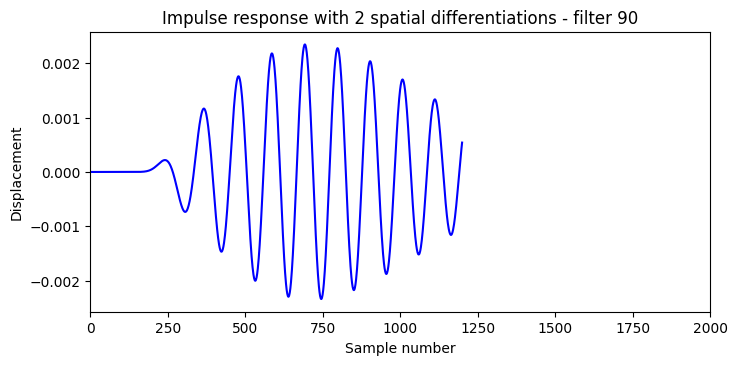

In [7]:
plt.figure(figsize = (8, 8))
plt.subplot(211)
plt.xlim(0,2000)
plt.ylabel('Displacement')
plt.xlabel('Sample number')
plt.title('Impulse response with 2 spatial differentiations - filter 90')
plt.plot(numpy.arange(len(diff2[89])), diff2[89], 'b')
plt.show()

# Magnitude response - without spatial differentiation (filter 72)

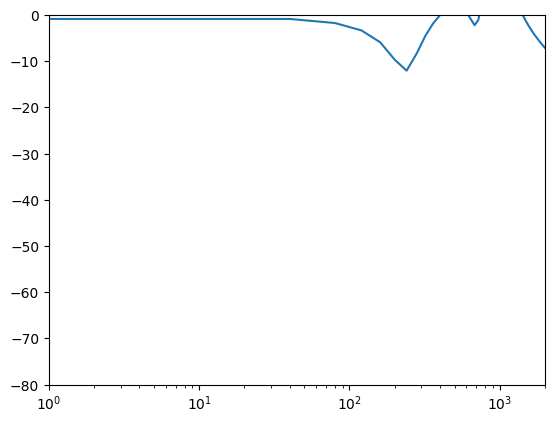

In [8]:
mag_response = []

for i in range(128):
    yf = numpy.fft.fft(displacement_output[i])
    yf = abs(yf)
    numpy.seterr(divide = 'ignore') 
    yf = 20 * numpy.log10(yf)
    mag_response.append(yf)
    freqs = numpy.arange(0, len(signal)) * fs/len(signal)

plt.xlim(1, 2000)
plt.ylim(-80, 0)
plt.semilogx(freqs, mag_response[71])
plt.show()

# Magnitude response - with two spatial differentiations (filter 72)

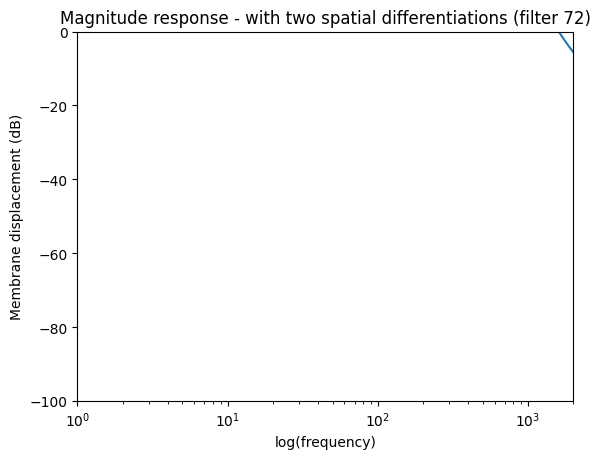

In [9]:
diff2_mag_response = []

for i in range(128):
    yf = numpy.fft.fft(diff2[i])
    yf = abs(yf)
    numpy.seterr(divide = 'ignore') 
    yf = 20 * numpy.log10(yf)
    diff2_mag_response.append(yf)
    freqs = numpy.arange(0, len(signal)) * fs/len(signal)

plt.xlim(1, 2000)
plt.ylim(-100, 0)
plt.xlabel('log(frequency)')
plt.ylabel('Membrane displacement (dB)')
plt.title('Magnitude response - with two spatial differentiations (filter 72)')
plt.semilogx(freqs, diff2_mag_response[71])
plt.show()

# Membrane displacement against section number

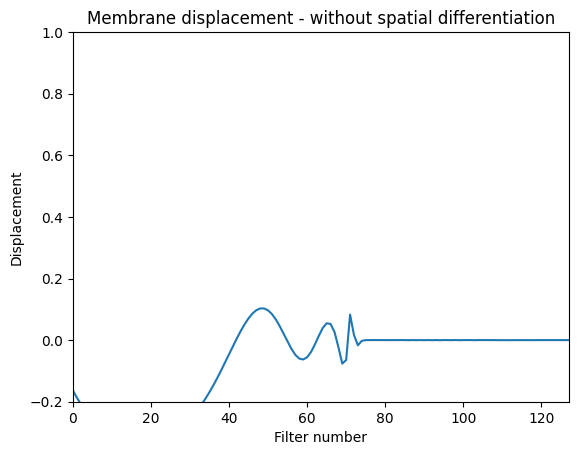

In [10]:
plt.xlim(0, 127)
plt.ylim(-0.2, 1)

displacement_output = numpy.array(displacement_output)

plt.xlabel('Filter number')
plt.ylabel('Displacement')
plt.title('Membrane displacement - without spatial differentiation')

plt.plot(numpy.arange(0,128), displacement_output[:,len(displacement_output[0]) - 1])
plt.show()

# Membrane displacement (2 spatial differentiations)

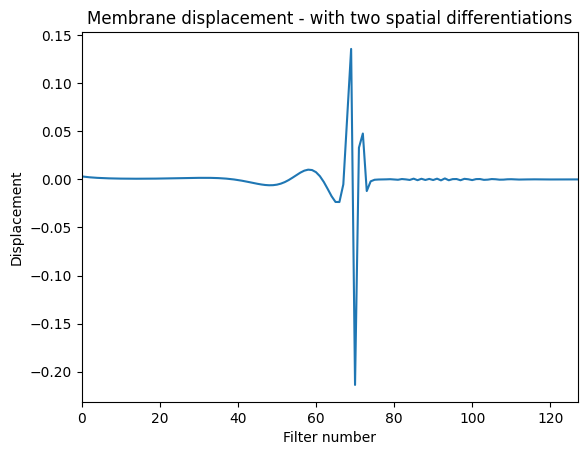

In [11]:
plt.xlim(0, 127)
#plt.ylim(-0.2, 0.2)

diff2 = numpy.array(diff2)

plt.xlabel('Filter number')
plt.ylabel('Displacement')
plt.title('Membrane displacement - with two spatial differentiations')

plt.plot(numpy.arange(0,128), diff2[:,len(diff2[0]) - 1])
plt.show()

# TLT L2 validation

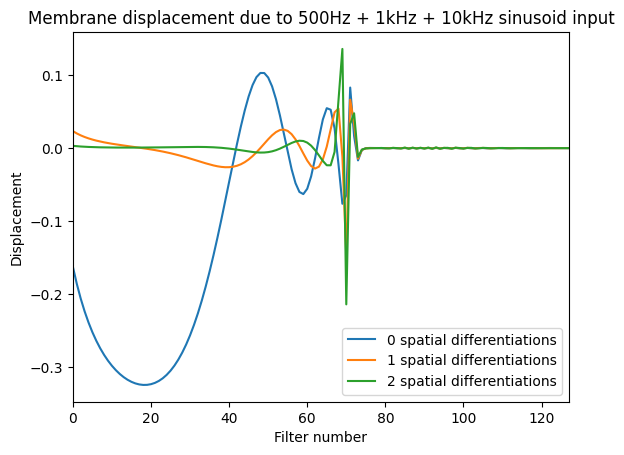

In [12]:
plt.xlim(0, 127)
#plt.ylim(-1, 1)

displacement_output = numpy.array(displacement_output)
diff1 = numpy.array(diff1)
diff2 = numpy.array(diff2)

plt.plot(numpy.arange(0,128), displacement_output[:,len(displacement_output[0]) - 1])
plt.plot(numpy.arange(0,128), diff1[:,len(diff1[0]) - 1])
plt.plot(numpy.arange(0,128), diff2[:,len(diff2[0]) - 1])
plt.xlabel('Filter number')
plt.ylabel('Displacement')
plt.title('Membrane displacement due to 500Hz + 1kHz + 10kHz sinusoid input')
plt.legend(['0 spatial differentiations', '1 spatial differentiations', '2 spatial differentiations'])
plt.show()

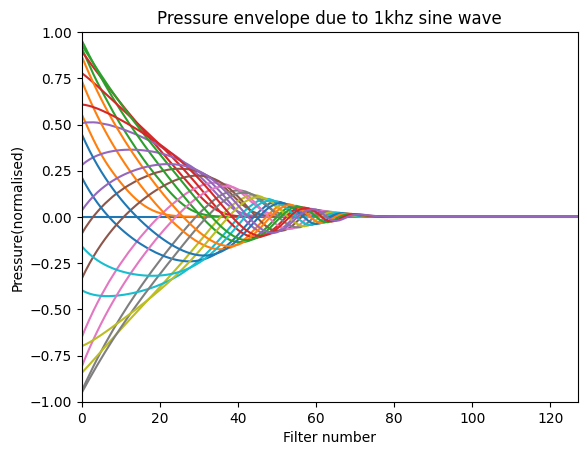

In [13]:
pressure_output = numpy.array(pressure_output)

plt.xlim(0, 127)
plt.ylim(-1, 1)
plt.xlabel('Filter number')
plt.ylabel('Pressure(normalised)')
plt.title('Pressure envelope due to 1khz sine wave')

for i in range(int(len(pressure_output) / 5)):
    plt.plot(numpy.arange(0,128), pressure_output[:,i*5])
plt.show()

# Level 3

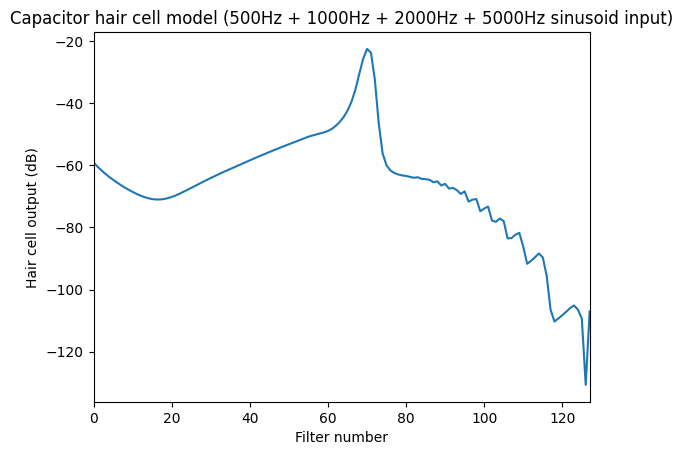

In [14]:
displacement_rectified = []
electrical_output = []

fc = 30

c0 = numpy.exp(-2 * pi * fc / fs)

for i in range(128):
    displacement_rectified.append(numpy.where(diff2[i]<0, 0, diff2[i]))
    y = []
    for j in range(len(diff2[i])):
        if j == 0:
            y.append((1 - c0) * displacement_rectified[i][j])
        else: 
            y.append((1 - c0) * displacement_rectified[i][j] + c0 * y[j - 1])
    electrical_output.append(y)

electrical_output = numpy.array(electrical_output)
electrical_output = 20 * numpy.log10(electrical_output)

plt.xlim(0, 127)
#plt.ylim(0, 0.5)
plt.xlabel('Filter number')
plt.ylabel('Hair cell output (dB)')
plt.title('Capacitor hair cell model (500Hz + 1000Hz + 2000Hz + 5000Hz sinusoid input)')
plt.plot(numpy.arange(0,128), electrical_output[:,len(electrical_output[0]) - 1])
plt.show()
    

# Filter central frequency

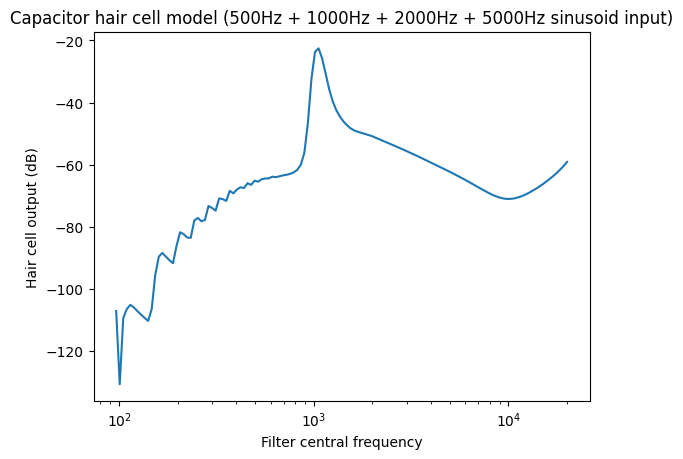

In [15]:
#plt.xlim(1, 24000)
#plt.ylim(-100, 100)
plt.xlabel('Filter central frequency')
plt.ylabel('Hair cell output (dB)')
plt.title('Capacitor hair cell model (500Hz + 1000Hz + 2000Hz + 5000Hz sinusoid input)')

#electrical_output = 20 * numpy.log10(electrical_output)
plt.semilogx(fp, electrical_output[:,len(electrical_output[0]) - 1])
plt.show()

# Accumulator hair cell model

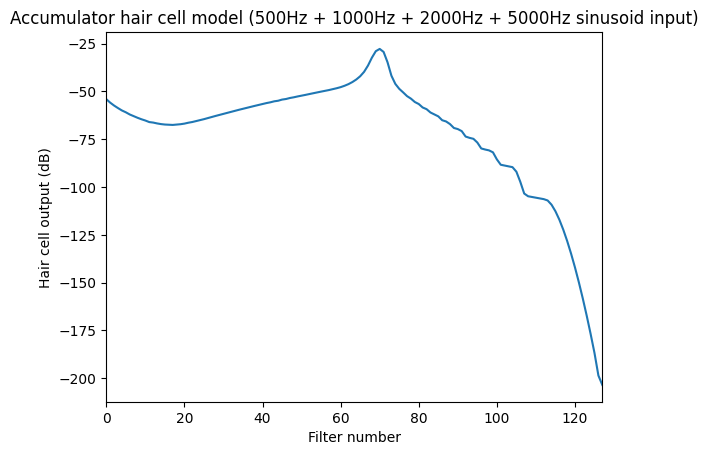

In [16]:
displacement_rectified = []
electrical_output = []

for i in range(128):
    displacement_rectified.append(numpy.where(diff2[i]<0, 0, diff2[i]))
    y = []
    accumulator = 0
    for j in range(len(diff2[i])):
        if j % 768 == 0:
            if len(y) == 0:
                y.append(accumulator / 768)
            else:
                y.append(accumulator / 768 + y[len(y) - 1])
            accumulator = 0
        else:
            accumulator += displacement_rectified[i][j]
    electrical_output.append(y)

electrical_output = numpy.array(electrical_output)
    
plt.xlim(0, 127)
#plt.ylim(-100, 100)
plt.xlabel('Filter number')
plt.ylabel('Hair cell output (dB)')
plt.title('Accumulator hair cell model (500Hz + 1000Hz + 2000Hz + 5000Hz sinusoid input)')

electrical_output = 20 * numpy.log10(electrical_output)
plt.plot(numpy.arange(0,128), electrical_output[:,len(electrical_output[0]) - 1])
plt.show()

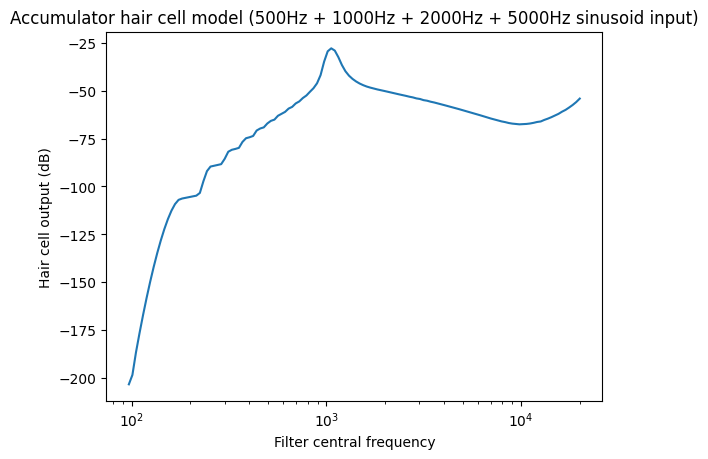

In [17]:
#plt.xlim(1, 24000)
#plt.ylim(-100, 100)
plt.xlabel('Filter central frequency')
plt.ylabel('Hair cell output (dB)')
plt.title('Accumulator hair cell model (500Hz + 1000Hz + 2000Hz + 5000Hz sinusoid input)')

#electrical_output = 20 * numpy.log10(electrical_output)
plt.semilogx(fp, electrical_output[:,len(electrical_output[0]) - 1])
plt.show()

# FFT vs filter bank

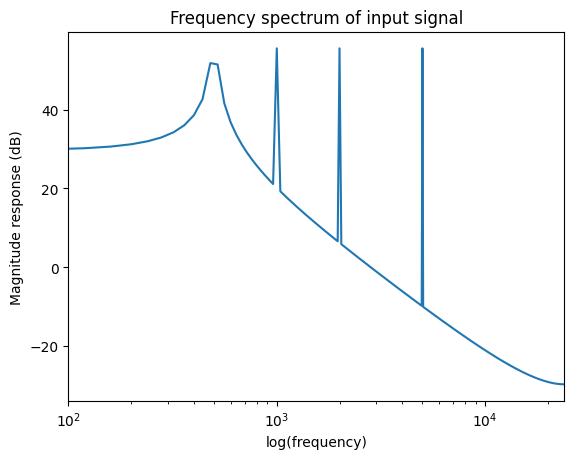

In [18]:
signal = generate_sine_wave(500) + generate_sine_wave(1000) + generate_sine_wave(2000) + generate_sine_wave(5000)

yf = numpy.fft.fft(signal)
yf = abs(yf)
yf = 20 * numpy.log10(yf)

freqs = numpy.arange(0, len(signal)) * fs/len(signal)

plt.xlim(100, 24000)
#plt.ylim(-20, 100)
plt.xlabel('log(frequency)')
plt.ylabel('Magnitude response (dB)')
plt.title('Frequency spectrum of input signal')
plt.semilogx(freqs, yf)
plt.show()